In [1]:
import math
import random
import itertools

import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from scipy.signal import resample

# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *   

import pydicom as pyd
import re
import cv2

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
SEED = 300
seed_everything(SEED)

In [3]:
from efficientnet_pytorch import EfficientNet

In [4]:
def getEfficientNet(model_name,pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = EfficientNet.from_name(model_name, override_params={'num_classes':3})

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [5]:
model_path = '/home/jfang/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth'
arch = getEfficientNet('efficientnet-b4')    

In [6]:
work_dir2 = '../../../../data/covid-19'

In [7]:
import os
os.listdir(work_dir2)

['saved-models', 'chest_xray', 'covid-chestxray-dataset-master']

In [8]:
os.listdir(work_dir2+'/covid-chestxray-dataset-master')

['.gitignore',
 'README.md',
 'images',
 'metadata.csv',
 'CONTRIBUTING.md',
 'docs']

In [9]:
new_data = pd.read_csv(f'{work_dir2}/covid-chestxray-dataset-master/metadata.csv')

In [10]:
new_data.drop(['doi', 'clinical notes', 'other notes', 'Unnamed: 16', 'survival', 'date', 'location', 'offset', 'sex','license', 'age'], axis = 1, inplace = True)

In [11]:
new_data = new_data[new_data.modality == 'X-ray']
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
141,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
142,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
143,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
144,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [12]:
new_data['view'].value_counts()

PA           92
L            11
AP           10
AP Supine    10
Name: view, dtype: int64

In [13]:
new_data = new_data[new_data.view != 'L']
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
141,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
142,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
143,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
144,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [14]:
new_data['finding'].value_counts()

COVID-19         89
SARS             11
Streptococcus     6
ARDS              4
Pneumocystis      1
No Finding        1
Name: finding, dtype: int64

In [15]:
new_data = new_data[new_data.finding.isin(['COVID-19','SARS'])]

In [16]:
new_data.reset_index(drop=True, inplace=True)

In [17]:
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
95,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
96,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
97,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
98,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [18]:
i = 1
for name in list(map(str,list(new_data.Patientid))):
    if not name.startswith('_'):
        if i < 5:
            print(name, end=(10-len(name))*' ')
            i+=1
        else:
            print(name)
            i = 1

2         2         2         2         4
4         6         6         3         3
3         7         7         8         9
9         10        10        10        11
12        13        13        13        13
14        15        15        15        16
17        17        17        18        19
19        19        19        20        21
22        23        24        32        33
34        35        36        36        37
37        39        40        41        42
43        44        45        46        47
48        49        50        51        51
52        53        54        55        56
57        57        58        58        58
59        59        60        61        62
62        63        64        65        67
67        68        68        69        69
70        70        71        71        71
72        73        73        74        75


In [19]:
extlist = list(map(lambda x: x.split('.')[-1], list(new_data.filename)))

In [20]:
from collections import Counter

print(list(Counter(extlist).keys()))
print(list(Counter(extlist).values())) 

['jpeg', 'jpg', 'png']
[60, 28, 12]


In [21]:
cutpoint = list(filter(lambda x: list(new_data.Patientid)[x] != list(new_data.Patientid)[x+1]
                ,range(0,len(list(new_data.Patientid))-1)))
    

In [22]:
i = 1
for name in list(map(str,[j+1 for j in cutpoint])):
    if not name.startswith('_'):
        if i < 5:
            print(name, end=(10-len(name))*' ')
            i+=1
        else:
            print(name)
            i=1

4         6         8         11        13
14        16        19        20        21
25        26        29        30        33
34        38        39        40        41
42        43        44        45        46
47        49        51        52        53
54        55        56        57        58
59        60        61        62        63
65        66        67        68        69
70        72        75        77        78
79        81        82        83        84
86        88        90        92        95
96        98        99        

In [23]:
cov_filelist = list(new_data.filename)

In [24]:
#os.makedirs(f"{work_dir2}/chest_xray/train/COVID&SARS")
#os.makedirs(f"{work_dir2}/chest_xray/test/COVID&SARS")

In [25]:
os.listdir(f'{work_dir2}/covid-chestxray-dataset-master')

['.gitignore',
 'README.md',
 'images',
 'metadata.csv',
 'CONTRIBUTING.md',
 'docs']

In [26]:
import shutil

In [27]:
'''
for fn in cov_filelist[:86]:
    shutil.copy(f'{work_dir2}/covid-chestxray-dataset-master/images/{fn}',
                f"{work_dir2}/chest_xray/train/COVID&SARS")
'''

'\nfor fn in cov_filelist[:86]:\n    shutil.copy(f\'{work_dir2}/covid-chestxray-dataset-master/images/{fn}\',\n                f"{work_dir2}/chest_xray/train/COVID&SARS")\n'

In [28]:
'''
for fn in cov_filelist[86:]:
    shutil.copy(f'{work_dir2}/covid-chestxray-dataset-master/images/{fn}',
                f"{work_dir2}/chest_xray/test/COVID&SARS")
'''

'\nfor fn in cov_filelist[86:]:\n    shutil.copy(f\'{work_dir2}/covid-chestxray-dataset-master/images/{fn}\',\n                f"{work_dir2}/chest_xray/test/COVID&SARS")\n'

In [29]:
!ls ../../../../data/covid-19/chest_xray

models	train  valid


In [30]:
newImgDataBunch = (ImageDataBunch.from_folder(path=f'{work_dir2}/chest_xray', 
                                              size=224, 
                                              bs=32, 
                                              ds_tfms=get_transforms())

                  .normalize())

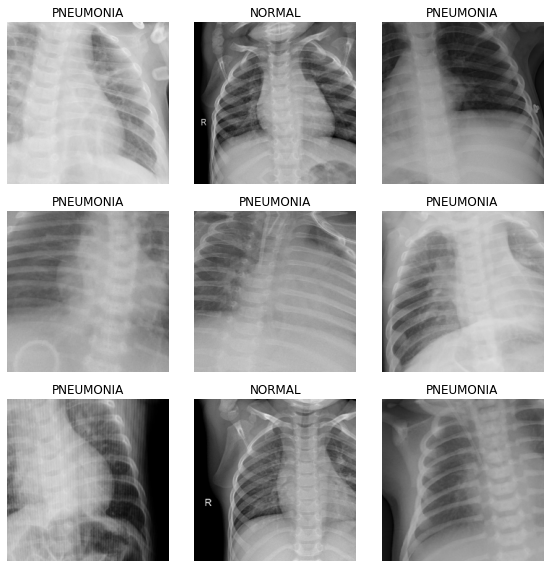

In [31]:
newImgDataBunch.show_batch(rows=3, figsize=(8,8))

In [32]:
newImgDataBunch.classes

['COVIDnSARS', 'NORMAL', 'PNEUMONIA']

In [33]:
w = torch.cuda.FloatTensor([11,2,1])

In [34]:
model_path = '/home/jfang/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth'
arch = getEfficientNet('efficientnet-b4')    

In [35]:
def getLearner():
    return Learner(newImgDataBunch, arch,
                      metrics=error_rate, callback_fns=ShowGraph,
                      loss_func=torch.nn.CrossEntropyLoss(weight=w))

learner3 = getLearner()

In [36]:
learner3.load(f'/home/jfang/fastai/data/covid-19/saved-models/model_2')

Learner(data=ImageDataBunch;

Train: LabelList (5302 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Valid: LabelList (654 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48

In [37]:
m = learner3.model.eval()

In [177]:
idx=529
x,y = newImgDataBunch.valid_ds[idx]

In [178]:
xb,_ = newImgDataBunch.one_item(x)
xb_im = Image(newImgDataBunch.denorm(xb)[0])
xb = xb.cuda()

In [179]:
from fastai.callbacks.hooks import *

In [180]:
layer_conv = 3
mykeys = m._modules.keys()
k = list(mykeys)
m0 = m._modules[k[layer_conv]]
print(m0)
def hooked_backward(cat=y):
    m0 = m._modules[k[layer_conv]]
    
    with hook_output(m0) as hook_a: 
        with hook_output(m0, grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

Conv2dStaticSamePadding(
  448, 1792, kernel_size=(1, 1), stride=(1, 1), bias=False
  (static_padding): Identity()
)


In [181]:
m

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [182]:
k

['_conv_stem',
 '_bn0',
 '_blocks',
 '_conv_head',
 '_bn1',
 '_avg_pooling',
 '_dropout',
 '_fc',
 '_swish']

In [183]:
hook_a,hook_g = hooked_backward()

In [184]:
hook_a.stored.shape

torch.Size([1, 1792, 7, 7])

In [185]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([1792, 7, 7])

In [186]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [187]:
avg_acts

tensor([[ 1.8187,  1.1976,  0.4957,  0.4378,  0.6327,  0.5958,  1.4399],
        [ 1.5823,  0.6696,  0.5276,  0.5000,  0.4241,  0.5807,  1.5712],
        [ 1.4821,  0.3769,  0.0540,  0.1781, -0.1396,  0.5398,  1.2351],
        [ 0.5964, -1.2952, -1.6430, -1.3456, -1.3514, -0.7951,  0.4292],
        [ 0.1544, -1.5479, -1.9046, -1.6722, -1.4151, -1.0434,  0.2902],
        [ 0.3022, -0.4023, -0.3571,  0.0736,  0.1625,  0.2503,  1.0834],
        [ 0.9167,  0.6379,  1.1074,  1.4885,  1.7420,  1.5491,  1.8095]])

In [188]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

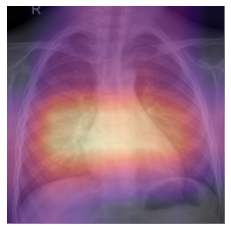

In [189]:
show_heatmap(avg_acts*-1)

In [56]:
# 0-397: pneumonia
# 398-639: normal
# 640-653: covid-19

654